In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import logging

from cts_recommender.settings import get_settings
from cts_recommender.environments.TV_environment import TVProgrammingEnvironment
from cts_recommender.logging_setup import setup_logging
from cts_recommender.models.contextual_thompson_sampler import ContextualThompsonSampler
from cts_recommender.models.audience_regression.audience_ratings_regressor import AudienceRatingsRegressor
from cts_recommender.io import readers


cfg = get_settings()
setup_logging("INFO")
logger = logging.getLogger(__name__)

## Load environment

In [3]:
# Load data
from cts_recommender.features.catalog_schema import CATALOG_DTYPES, HISTORICAL_PROGRAMMING_DTYPES, enforce_dtypes

catalog_df = readers.read_parquet(cfg.processed_dir / "whatson" / "whatson_catalog.parquet")
# Enforce correct dtypes (especially datetime columns)
catalog_df = enforce_dtypes(catalog_df, CATALOG_DTYPES, skip_missing=True)

historical_programming_df = readers.read_parquet(cfg.processed_dir / "programming" / "historical_programming.parquet")
# Enforce correct dtypes for historical programming
historical_programming_df = enforce_dtypes(historical_programming_df, HISTORICAL_PROGRAMMING_DTYPES, skip_missing=True)

audience_model = AudienceRatingsRegressor()
audience_model.load_model(cfg.models_dir / "audience_ratings_model.joblib")

# Initialize environment
env = TVProgrammingEnvironment(catalog_df, historical_programming_df, audience_model)

2025-10-23 16:51:43 WARNING cts_recommender.features.catalog_schema: Column 'tv_rights_start': 1 values could not be converted and set to NaT
2025-10-23 16:51:43 INFO cts_recommender.features.catalog_schema: Column 'tv_rights_end': Capped 50 out-of-bounds dates to pandas boundaries
2025-10-23 16:51:44 INFO cts_recommender.models.audience_regression.audience_ratings_regressor: Model loaded from data/models/audience_ratings_model.joblib with 71 features
2025-10-23 16:51:44 INFO cts_recommender.environments.TV_environment: Setting up CompetitorDataManager...
2025-10-23 16:51:44 INFO cts_recommender.environments.TV_environment: Setting up Scalers...
2025-10-23 16:51:44 INFO cts_recommender.environments.TV_environment: Setting up RewardCalculator...
2025-10-23 16:51:44 INFO cts_recommender.environments.reward: RewardCalculator initialized successfully.


In [4]:
# Load curator model
from cts_recommender.models.curator_logistic_regressor import load_curator_model

curator_model = load_curator_model(cfg.models_dir / "curator_logistic_model.joblib")

2025-10-23 16:51:44 INFO cts_recommender.models.curator_logistic_regressor: Loading curator model from data/models/curator_logistic_model.joblib
2025-10-23 16:51:44 INFO cts_recommender.models.curator_logistic_regressor: Curator model loaded successfully


## Load CTS model

In [5]:
cts = ContextualThompsonSampler.load(cfg.models_dir / "cts_model.npz")

### Visualize marginal distribution

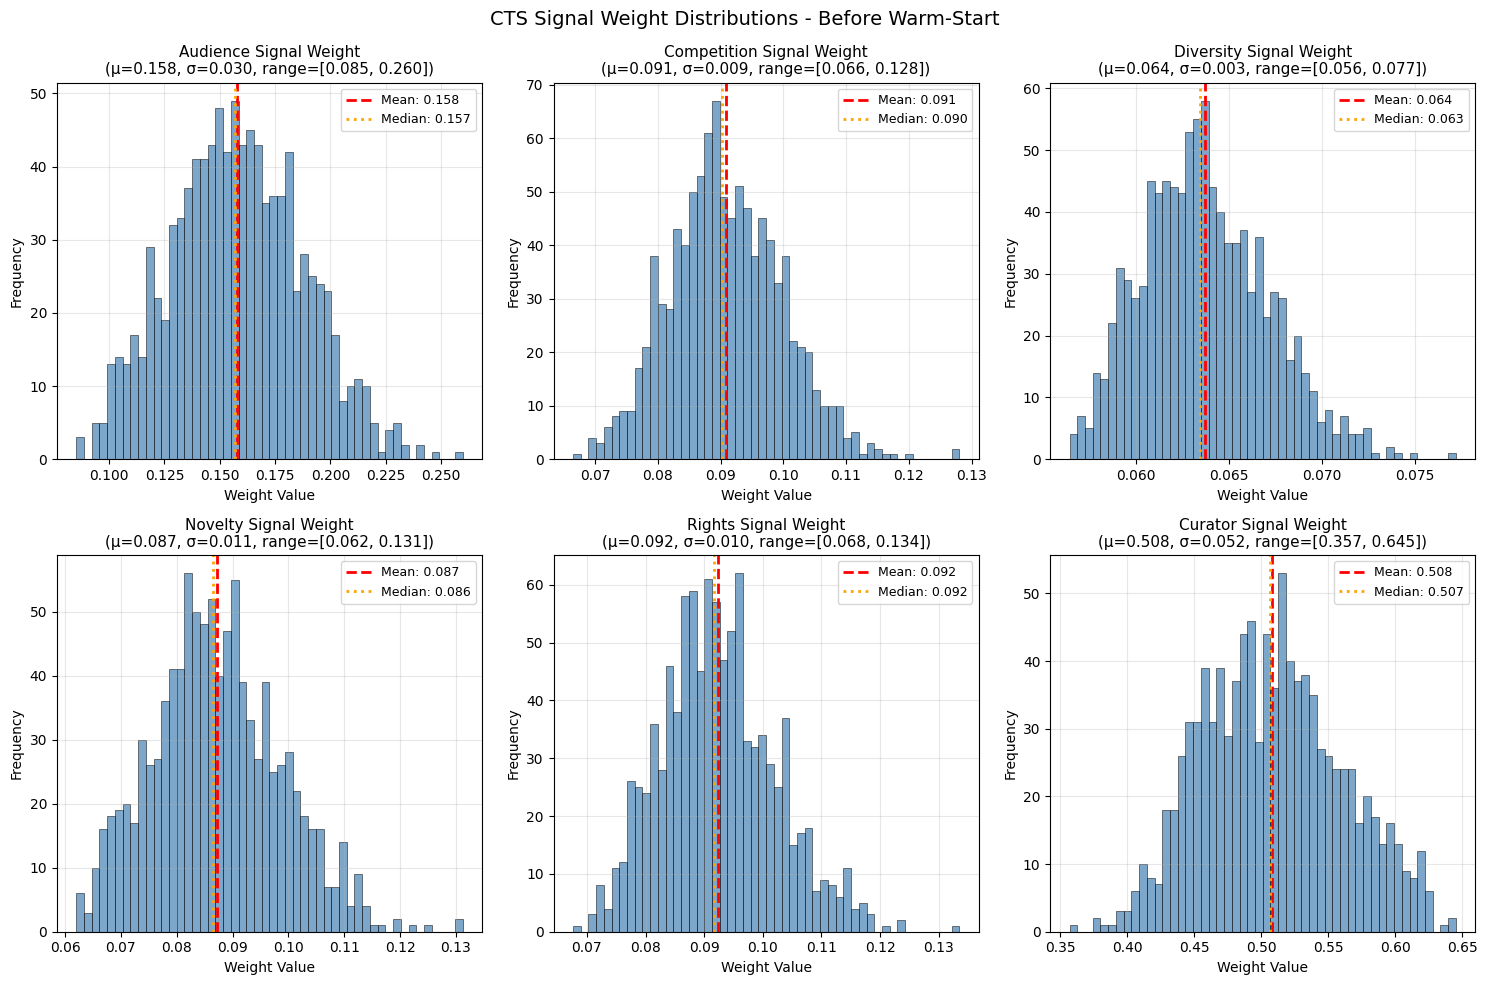

In [6]:
from cts_recommender.utils.visualization import visualize_cts_signal_weight_distributions
import matplotlib.pyplot as plt
# Visualize weight distribution to ensure desired behaviour
fig, axes = visualize_cts_signal_weight_distributions(cts_model=cts, env=env)
plt.suptitle('CTS Signal Weight Distributions - Before Warm-Start', fontsize=14, y=0.98)
plt.show()

## Test Recommendation Loop

In [7]:
# Set up test dates and parameters
from cts_recommender.environments.schemas import Context, Season, Channel
from cts_recommender.utils import dates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Test dates from today back 
today = datetime.now()
test_dates = [
    pd.Timestamp(today - timedelta(days=i)) for i in range(7, 0, -1)
]

# Recommendation parameters
hour_options = [10, 21, 23]
channel_options = [Channel.RTS1, Channel.RTS2]
num_recommendations = 5  # Top-K slate size

# Signal names for display
signal_names = ['audience', 'competition', 'diversity', 'novelty', 'rights', 'curator_prob']

print(f"Testing CTS on {len(test_dates)} dates with interactive recommendations")
print(f"Test dates: {[d.strftime('%Y-%m-%d') for d in test_dates]}")
print(f"Hours: {hour_options}, Channels: {[c.value for c in channel_options]}")
print(f"Slate size: {num_recommendations}\\n")

Testing CTS on 7 dates with interactive recommendations
Test dates: ['2025-10-16', '2025-10-17', '2025-10-18', '2025-10-19', '2025-10-20', '2025-10-21', '2025-10-22']
Hours: [10, 21, 23], Channels: ['RTS 1', 'RTS 2']
Slate size: 5\n


In [8]:
# Import interactive testing utilities
from cts_recommender.interactive.interactive_testing import InteractiveTester

# Track history
recommendation_history = []
weight_evolution = []

### Interactive Recommendation Loop

In [12]:
# Initialize interactive tester
tester = InteractiveTester(
    env=env,
    cts_model=cts,
    curator_model=curator_model,
    catalog_df=catalog_df
)

# Generate test contexts
contexts = tester.generate_test_contexts(num_days=7)

print(f"Generated {len(contexts)} test contexts")
print(f"Date range: {contexts[0][0].strftime('%Y-%m-%d')} to {contexts[-1][0].strftime('%Y-%m-%d')}\n")

# Run interactive testing loop
tester.run_interactive_loop(contexts=contexts, num_recommendations=5)

# Store results for visualization
recommendation_history = tester.recommendation_history
weight_evolution = tester.weight_evolution

Generated 7 test contexts
Date range: 2025-10-16 to 2025-10-22


Starting Interactive CTS Testing
Testing 7 contexts



Computing signals for 2025-10-16:   0%|          | 0/1759 [00:00<?, ?movie/s]


DATE: 2025-10-16
CONTEXT: 10:00 on Thursday | RTS 2 | fall

(24,)


/Users/maetzth/python/RTS-curator-recommendation-system/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 42 features, but RandomForestRegressor is expecting 71 features as input.

### Visualize Weight Evolution

In [ ]:
# Plot weight evolution over recommendations
import matplotlib.pyplot as plt
from cts_recommender.utils.interactive import SIGNAL_NAMES

if len(weight_evolution) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Extract weights for each signal
    iterations = list(range(1, len(weight_evolution) + 1))
    
    for i, sig_name in enumerate(SIGNAL_NAMES):
        weights = [w['weights'][i] for w in weight_evolution]
        ax.plot(iterations, weights, marker='o', label=sig_name, linewidth=2)
    
    ax.set_xlabel('Recommendation Iteration', fontsize=12)
    ax.set_ylabel('Signal Weight', fontsize=12)
    ax.set_title('CTS Signal Weight Evolution Through Feedback', fontsize=14, fontweight='bold')
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nWeight Evolution Summary:")
    print(f"{'Signal':<15} {'Initial':<10} {'Final':<10} {'Change':<10}")
    print("-" * 45)
    for i, sig_name in enumerate(SIGNAL_NAMES):
        initial = weight_evolution[0]['weights'][i]
        final = weight_evolution[-1]['weights'][i]
        change = final - initial
        print(f"{sig_name:<15} {initial:<10.4f} {final:<10.4f} {change:+.4f}")
else:
    print("No weight evolution data to display")

In [ ]:
# Compare CTS weight distributions before and after testing
from cts_recommender.utils.interactive import SIGNAL_NAMES

if len(recommendation_history) > 0:
    fig, axes = visualize_cts_signal_weight_distributions(cts_model=cts, env=env)
    plt.suptitle('CTS Signal Weight Distributions - After Interactive Testing', fontsize=14, y=0.98)
    plt.show()
    
    print("\n📊 The CTS model has been updated based on your feedback!")
    print(f"   Total recommendations: {len(recommendation_history)}")
    print(f"   Acceptance rate: 100% (all accepted)")
    
    # Show which signals were indicated as pertinent
    signal_feedback_count = np.zeros(len(SIGNAL_NAMES))
    for rec in recommendation_history:
        if rec.get('y_signals') is not None:
            signal_feedback_count += rec['y_signals']
    
    if signal_feedback_count.sum() > 0:
        print("\n   Signals marked as pertinent:")
        for i, sig_name in enumerate(SIGNAL_NAMES):
            if signal_feedback_count[i] > 0:
                print(f"     - {sig_name}: {int(signal_feedback_count[i])} times")